In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue')
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})

In [2]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon, Rectangle

In [3]:
moves_df = pd.read_csv('../data/user_moves.csv')
location_lat_lon_df = pd.read_csv('../data/location_lat_lon.csv')

In [4]:
to_loc_count_df = moves_df.groupby('to_loc')['user_id'].nunique()
from_loc_count_df = moves_df.groupby('from_loc')['user_id'].nunique()

loc_count_df = to_loc_count_df.add(from_loc_count_df, fill_value=0).rename_axis('location').reset_index(name="num_users")
loc_count_lat_lon_df = loc_count_df.merge(location_lat_lon_df, how='left', left_on='location', right_on='location')

# Reordering here because order will matter later during map plotting.
loc_count_lat_lon_df.sort_values('num_users', ascending=True, inplace=True)
loc_count_lat_lon_df.head()

,location,num_users,lat,lon
1072,"Opelika, AL",1.0,32.67,-85.37
353,"Deer Park, TX",1.0,29.69,-95.11
351,"Decatur, IL",1.0,39.82,-88.92
955,"Morristown, TN",1.0,36.21,-83.30
958,"Moses Lake, WA",1.0,47.13,-119.27


In [5]:
# Need to do this because of later handling of AK and HI in the plotted map.
AK_loc_count_lat_lon_df = loc_count_lat_lon_df[loc_count_lat_lon_df['location'].str.contains(', AK')]
HI_loc_count_lat_lon_df = loc_count_lat_lon_df[loc_count_lat_lon_df['location'].str.contains(', HI')]

In [6]:
moves_with_lat_lon_df = moves_df.merge(location_lat_lon_df, how='left', left_on='from_loc', right_on='location', suffixes=['', '_from'])
moves_with_lat_lon_df = moves_with_lat_lon_df.merge(location_lat_lon_df, how='left', left_on='to_loc', right_on='location', suffixes=['', '_to'])
moves_with_lat_lon_df = moves_with_lat_lon_df.dropna(subset=['lat', 'lon', 'lat_to', 'lon_to'])
moves_with_lat_lon_df.head()

,user_id,from_loc,to_loc,location,lat,lon,location_to,lat_to,lon_to
0,1.924568e+09,"Portland, OR","San Jose, CA","Portland, OR",45.51,-122.69,"San Jose, CA",37.34,-121.90
1,1.007347e+09,"Bountiful, UT","Palo Alto, CA","Bountiful, UT",40.88,-111.87,"Palo Alto, CA",37.44,-122.15
2,2.404259e+09,"Fort Lauderdale, FL","San Diego, CA","Fort Lauderdale, FL",26.13,-80.13,"San Diego, CA",32.72,-117.16
3,1.489600e+09,"Doral, FL","Denton, TX","Doral, FL",25.81,-80.36,"Denton, TX",33.22,-97.15
4,1.116627e+09,"Springville, UT","Torrance, CA","Springville, UT",40.18,-111.62,"Torrance, CA",33.84,-118.31


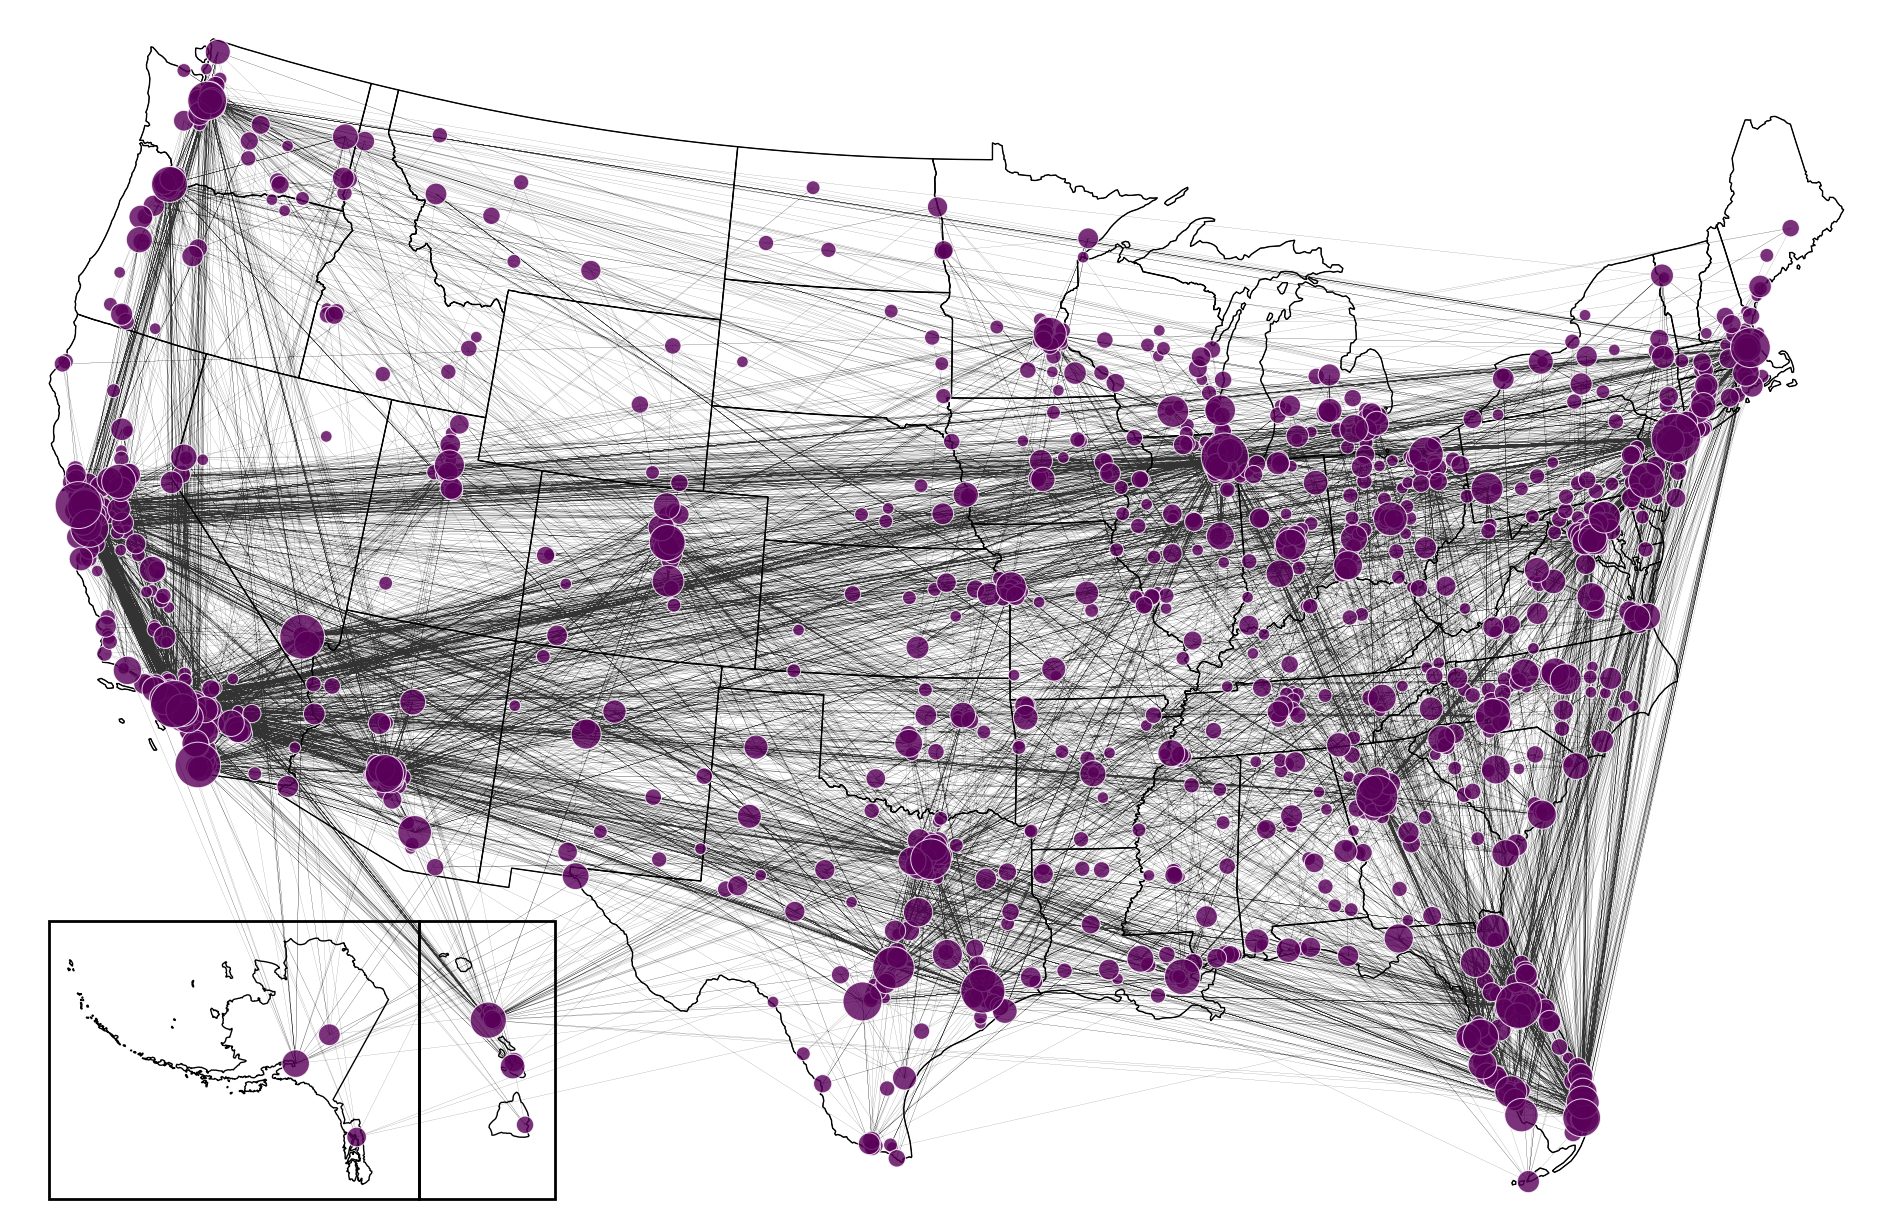

In [42]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

fig = plt.figure();
ax = fig.add_subplot(111, facecolor='w', frame_on=False);
fig.set_size_inches(26.5, 15.5);

coast_color = 'k'
state_bound_color = 'k'
state_face_color = 'white'

# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('../data/us_shapefile/cb_2016_us_state_20m', 'states', drawbounds=True, color=coast_color)

statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)

def alaska_correct(tup):
    (x, y) = tup
    return (0.25*x + 850000, 0.25*y - 900000)

def hawaii_correct(tup):
    (x, y) = tup
    return (0.8*x + 4200000, 0.8*y - 1000000)
    
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
    # Offset Alaska and Hawaii to the lower-left corner. 
        if statenames[nshape] == 'Alaska':
            # Alaska is too big. Scale it down first, then transate it. 
            seg = list(map(alaska_correct, seg))
        if statenames[nshape] == 'Hawaii':
            seg = list(map(hawaii_correct, seg))

        poly = Polygon(seg, facecolor=state_face_color, edgecolor=state_bound_color)
        ax.add_patch(poly)
        
ax.axis('off')

loc_count_lat_lon_df = loc_count_lat_lon_df.dropna()
map_points_lat = loc_count_lat_lon_df['lat']
map_points_lon = loc_count_lat_lon_df['lon']
values = loc_count_lat_lon_df['num_users']

# Create Point objects in map coordinates from dataframe lon
# and lat values
# I have a dataframe of coordinates
map_points = pd.Series(
                [Point(m(mapped_x, mapped_y))
                 for mapped_x, mapped_y in zip(map_points_lon,
                                               map_points_lat)]);

point_colors = '#590059'
point_sizes = lambda x: np.sqrt(x*5000)


# Create a scatterplot on the map
dev = m.scatter(
            [geom.x for geom in map_points],
            [geom.y for geom in map_points],
            s=point_sizes(values),
            c=point_colors,
            marker='o', lw=.75,
            edgecolor='w',
            alpha=0.8, antialiased=True,
            zorder=3);

AK_map_points_lat = AK_loc_count_lat_lon_df['lat']
AK_map_points_lon = AK_loc_count_lat_lon_df['lon']
AK_values = AK_loc_count_lat_lon_df['num_users']

alaska_points = pd.Series(
                [Point(alaska_correct(m(mapped_x, mapped_y)))
                 for mapped_x, mapped_y in zip(AK_map_points_lon,
                                               AK_map_points_lat)]);

dev_alaska = m.scatter(
                    [geom.x for geom in alaska_points],
                    [geom.y for geom in alaska_points],
                    s=point_sizes(AK_values),
                    c=point_colors,
                    marker='o', lw=.75,
                    edgecolor='w',
                    alpha=0.8, antialiased=True,
                    zorder=3);

HI_map_points_lat = HI_loc_count_lat_lon_df['lat']
HI_map_points_lon = HI_loc_count_lat_lon_df['lon']
HI_values = HI_loc_count_lat_lon_df['num_users']

hawaii_points = pd.Series(
                [Point(hawaii_correct(m(mapped_x, mapped_y)))
                 for mapped_x, mapped_y in zip(HI_map_points_lon,
                                               HI_map_points_lat)]);

dev_hawaii = m.scatter(
                    [geom.x for geom in hawaii_points],
                    [geom.y for geom in hawaii_points],
                    s=point_sizes(HI_values),
                    c=point_colors,
                    marker='o', lw=.75,
                    edgecolor='w',
                    alpha=0.8, antialiased=True,
                    zorder=3);

plot_x_list = list()
plot_y_list = list()
for index, row in moves_with_lat_lon_df.iterrows():
    if ', HI' in row['from_loc']:
        (from_point_x, from_point_y) = hawaii_correct(m(row['lon'], row['lat']))
    elif ', AK' in row['from_loc']:
        (from_point_x, from_point_y) = alaska_correct(m(row['lon'], row['lat']))
    else:
        (from_point_x, from_point_y) = m(row['lon'], row['lat'])
        
    if ', HI' in row['to_loc']:
        (to_point_x, to_point_y) = hawaii_correct(m(row['lon_to'], row['lat_to']))
    elif ', AK' in row['to_loc']:
        (to_point_x, to_point_y) = alaska_correct(m(row['lon_to'], row['lat_to']))
    else:
        (to_point_x, to_point_y) = m(row['lon_to'], row['lat_to'])

        
    plot_x_list += [from_point_x, to_point_x, None]
    plot_y_list += [from_point_y, to_point_y, None]
    
plt.plot(plot_x_list,
         plot_y_list,
         linewidth=0.1, c='k', alpha=0.8, 
         zorder=1)
    
inset_color = 'k'
inset_width = 2
ax.add_patch(Rectangle((100000, 10000),950000,715000,linewidth=inset_width,edgecolor=inset_color,facecolor='none', zorder=10));
ax.add_patch(Rectangle((1050000, 10000),350000,715000,linewidth=inset_width,edgecolor=inset_color,facecolor='none', zorder=10));

plt.savefig('../output/fig1a.pdf', dpi=300)